In [1]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

# plotting the car
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import scipy.misc
from scipy import ndimage

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

In [2]:
X = cas.MX.sym('X')
Y = cas.MX.sym('Y')
Phi = cas.MX.sym('Phi')
Delta = cas.MX.sym('Delta')
V = cas.MX.sym('V')
s = cas.MX.sym('s')

delta_u = cas.MX.sym('delta_u')
v_u = cas.MX.sym('v_u')
x = cas.vertcat(X, Y, Phi, Delta, V, s)
u = cas.vertcat(delta_u, v_u)

L = 1.0
ode = cas.vertcat(V * cas.cos(Phi),
                V * cas.sin(Phi),
                V * cas.tan(Delta) / L,
                delta_u,
                v_u,
                V)

f = cas.Function('f',[x,u],[ode],['x','u'],['ode'])

#  States

$\vec{x}$ = $[x, y, \phi, \delta, V, s]^T$

$\vec{u}$ = $[\delta^u, v^u]^T$

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [3]:
T = 3 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals
intg_options = {}
intg_options['tf'] = dt # from dt
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 6  #from 4

dae = {}  #What's a DAE?
dae['x'] = x
dae['p'] = u
dae['ode'] = f(x,u)
intg = cas.integrator('intg','rk', dae, intg_options)
res = intg(x0=x,p=u)
x_next = res['xf']
F = cas.Function('F',[x,u],[x_next],['x','u'],['x_next'])

# Car class (for plotting)

In [4]:
class Car:
    def __init__(self):
        self.L = 1.0 # m
        
    def get_frame(self, x, ax=None, amb=False):
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        else:
            fig = ax.get_figure()
            
            
        X, Y, Phi, Delta, V, S = x.flatten()
        if not amb:
            arr_img = plt.imread('red_car.png', format='png')
        else:
            arr_img = plt.imread('ambulance.png', format='png')
        degree = np.rad2deg(Phi)
        xy = (X, Y)
        rotated_img = ndimage.rotate(arr_img, degree)
        ax.axis('square')
        window_width = 12
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        
        if not amb:
            imagebox = OffsetImage(rotated_img, zoom=self.L * 1/(2*window_width)) #this zoom is to scale L=1
        else:
            imagebox = OffsetImage(rotated_img, zoom=1/3*self.L * 1/(2*window_width)) #this zoom is to scale L=1            
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (X, Y),frameon=False)
        ax.add_artist(ab)        

        return fig, ax        

# Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [5]:
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)

fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

## Optimization

In [45]:
ego_car = Car()
optional_suffix = ""
folder = "results/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)


min_dist = 2 * (2 * .5**2)**.5

# Initial Conditions
x0 = np.array([2*min_dist, .6*min_dist, 0, 0, 1.0, 0]).T
x0_2 = np.array([2*min_dist,-.6*min_dist, .0, 0, 1.0,0]).T
x0_amb = np.array([0, 0.0, 0, 0, 2.5,0]).T

n_cars = 3

# Generating Cost Matrices
q_lon, q_lat, q_phi, q_v, = 1., 5.0, 5.0, -.1,  #State costs
r_delta, r_vdot = 10.0, 10.0  #Control input costs

Q_k = np.eye(6)
Q_k[0,0] = q_lon
Q_k[1,1] = q_lat
Q_k[2,2] = q_phi
Q_k[3,3] = 0
Q_k[4,4] = q_v
Q_k[5,5] = q_lon
# C[6,6] = r_delta
# C[7,7] = r_vdot
Q_k[0,5] = -q_lon
Q_k[5,0] = -q_lon
R_k = np.eye(2)

n_mpc = int(20 / dt) #number of times we will run the MPC
n_mpc = 1 
for i_mpc in range(n_mpc):
    opti = cas.Opti()
    n_ctrl = 2
    n_state = 6
    
    
    #Variables
    x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
    x2_opt = opti.variable(n_state, N+1)
    xamb_opt = opti.variable(n_state, N+1)

    u_opt = opti.variable(n_ctrl, N)
    u2_opt = opti.variable(n_ctrl, N)
    uamb_opt = opti.variable(n_ctrl, N)

    p = opti.parameter(n_state, 1) #this will be the initial state
    p2 = opti.parameter(n_state, 1)
    pamb = opti.parameter(n_state, 1)

    
    x_desired = opti.variable(3, N+1)
    x2_desired = opti.variable(3, N+1)
    xamb_desired = opti.variable(3, N+1)

    
#     slack1 = opti.variable(1, N+1)
#     slack2 = opti.variable(1, N+1)
#     slack3 = opti.variable(1, N+1)    
    
    #### Costs
    
    car1_u_delta_cost = 10 * cas.sumsqr(u_opt[0,:])
    car1_u_v_cost = 1 * cas.sumsqr(u_opt[1,:])
    
    car1_lat_cost = np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
                cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
               for k in range(N+1)])
    car1_lon_cost = np.sum([(cas.cos(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
                cas.sin(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
               for k in range(N+1)]) 
    car1_phi_cost = cas.sumsqr(x_desired[2,:]-x_opt[2,:]) 
    car1_v_cost = cas.sumsqr(x_opt[4,:])   
    phid_1 = x_opt[4,:] * cas.tan(x_opt[3,:]) / L
    phid1_cost = cas.sumsqr(phid_1)
    
    k_lat1 = 10
    k_lon1 = 10
    k_phid1 = 1.0
    
    car1_costs = (car1_u_delta_cost + car1_u_v_cost + 
        k_lat1*car1_lat_cost + k_lon1*car1_lon_cost + car1_phi_cost + 
                  k_phid1 * phid1_cost +
                 q_v*car1_v_cost)
    
    
    car2_u_delta_cost = 10 * cas.sumsqr(u2_opt[0,:])
    car2_u_v_cost = 1 * cas.sumsqr(u2_opt[1,:])
    
    car2_lat_cost = np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
                cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
               for k in range(N+1)])
    car2_lon_cost = np.sum([(cas.cos(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
                cas.sin(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
               for k in range(N+1)]) 
    car2_phi_cost = cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]) 
    car2_v_cost = cas.sumsqr(x2_opt[4,:])   
    phid_2 = x2_opt[4,:] * cas.tan(x2_opt[3,:]) / L
    phid2_cost =cas.sumsqr(phid_2)    
    
    
    k_lat2 = 10
    k_lon2 = 10    
    k_phid2 = 1.0
    
    car2_costs = (car2_u_delta_cost + car2_u_v_cost + 
        k_lat2*car2_lat_cost + k_lon2*car2_lon_cost + car2_phi_cost + 
                  k_phid2*phid2_cost + q_v*car2_v_cost)    
    
    R_k = 1*R_k
    
#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)])

    amb_u_delta_cost = 10 * cas.sumsqr(uamb_opt[0,:])
    amb_u_v_cost = 0.1 * cas.sumsqr(uamb_opt[1,:])
    
    amb_lat_cost = np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
                cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
               for k in range(N+1)])

    
    amb_lon_cost = np.sum([(cas.cos(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
                cas.sin(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
               for k in range(N+1)]) 
    
    amb_phi_cost = cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:]) 
    amb_v_cost = cas.sumsqr(xamb_opt[4,:])  
    
    phid_amb= xamb_opt[4,:] * cas.tan(xamb_opt[3,:]) / L
    phidamb_cost =cas.sumsqr(phid_amb)   
    
    k_latamb = 10
    k_lonamb = 10        
    k_phidamb = 1.0
    amb_costs = (amb_u_delta_cost + amb_u_v_cost + 
                 k_latamb*amb_lat_cost + k_lonamb*amb_lon_cost + amb_phi_cost + 
                 k_phidamb * phidamb_cost + q_v*amb_v_cost
                )

#     slack_cost = cas.sumsqr(slack1) + cas.sumsqr(slack2) + cas.sumsqr(slack3)
    
    theta_1 = np.pi/4
    theta_2 = np.pi/4
    theta_amb = 0
    ######## optimization  ##################################
    opti.minimize(np.cos(theta_amb)*amb_costs + np.sin(theta_amb)*(car1_costs + car2_costs) + 
                  (np.cos(theta_1)*car1_costs + np.sin(theta_1)*amb_costs) + 
                  (np.cos(theta_2)*car2_costs + np.sin(theta_2)*amb_costs) 
#                   +0 * slack_cost  # slack is included here
                 )    
    ##########################################################


#     opti.subject_to( slack1 >= 0)
#     opti.subject_to( slack2 >= 0)
#     opti.subject_to( slack3 >= 0)

#     opti.subject_to( slack1 == 0)
#     opti.subject_to( slack2 == 0)
#     opti.subject_to( slack3 == 0)    
    
    #constraints
    
    for k in range(N):
        opti.subject_to( x_opt[:, k+1] == F(x_opt[:, k], u_opt[:, k]))

    for k in range(N+1):
        opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        
        
        
    opti.subject_to(opti.bounded(-np.pi/6, u_opt[0,:], np.pi/6))
    opti.subject_to(opti.bounded(-4, u_opt[1,:], 4)) # 0-60 around 4 m/s^2
    v_max = 10
    opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
    opti.subject_to(x_opt[:,0] == p)
    
    #Just repeat constraints for x2
    for k in range(N):
        opti.subject_to( x2_opt[:, k+1] == F(x2_opt[:, k], u2_opt[:, k]))
    for k in range(N+1):
        opti.subject_to( x2_desired[:, k] == fd(x2_opt[-1, k]) ) #This should be the trajectory dynamic constraint             
    
    
    opti.subject_to(opti.bounded(-np.pi/6, u2_opt[0,:], np.pi/6))
    opti.subject_to(opti.bounded(-4, u2_opt[1,:], 4))
    v_max = 10
    opti.subject_to(opti.bounded(0, x2_opt[4,:],v_max))    
    opti.subject_to(x2_opt[:,0] == p2)
    
    #ambulance
    for k in range(N):
        opti.subject_to( xamb_opt[:, k+1] == F(xamb_opt[:, k], uamb_opt[:, k]))
    for k in range(N+1):
        opti.subject_to( xamb_desired[:, k] == fd(xamb_opt[-1, k]) ) #This should be the trajectory dynamic constraint             
    
    
    opti.subject_to(opti.bounded(-np.pi/6, uamb_opt[0,:], np.pi/6))
    opti.subject_to(opti.bounded(-4, uamb_opt[1,:], 4))
    v_max = 20
    opti.subject_to(opti.bounded(0, xamb_opt[4,:],v_max))    
    opti.subject_to(xamb_opt[:,0] == pamb)    
    
#     min_dist = 0.6
    for k in range(N+1):
        opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 )
        opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )
        opti.subject_to( cas.sumsqr(x2_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )
    
    
    
    
    # constraints to help out
    opti.subject_to( opti.bounded(-1, x_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-1, x2_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-1, xamb_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
    opti.subject_to( opti.bounded(-10, x2_opt[1,:], 10) )
    opti.subject_to( opti.bounded(-10, xamb_opt[1,:], 10) )
    opti.subject_to( opti.bounded(-np.pi/2, x_opt[2,:], np.pi/2) )
    opti.subject_to( opti.bounded(-np.pi/2, x2_opt[2,:], np.pi/2) )
    opti.subject_to( opti.bounded(-np.pi/2, xamb_opt[2,:], np.pi/2) )    
    
    # constrain the lane deviations to prevent wacky solutions
#     opti.subject_to( opti.bounded(-5, x_opt[0,:] - x_desired[0,:], 5))
#     opti.subject_to( opti.bounded(-5, x2_opt[0,:] - x2_desired[0,:], 5))
    opti.subject_to( opti.bounded(-5, xamb_opt[0,:] - xamb_desired[0,:], 5))
    opti.subject_to( opti.bounded(-10, x_opt[1,:] - x_desired[1,:], 10))
    opti.subject_to( opti.bounded(-10, x2_opt[1,:] - x2_desired[1,:], 10))
    opti.subject_to( opti.bounded(-10, xamb_opt[1,:] - xamb_desired[1,:], 10))

    
    opti.solver('ipopt',{'warn_initial_bounds':True})
    
    opti.set_value(p,x0)
    opti.set_value(p2,x0_2)
    opti.set_value(pamb,x0_amb) 
    sol = opti.solve()
    
    x_mpc = sol.value(x_opt)
    u_mpc = sol.value(u_opt)

    x2_mpc = sol.value(x2_opt)
    u2_mpc = sol.value(u2_opt)
        
    x0 = x_mpc[:,1:2]
    x0_2 = x2_mpc[:,1:2]
    
    x_des = sol.value(x_desired)
    x2_des = sol.value(x2_desired)  
    
    xamb_mpc = sol.value(xamb_opt)
    
    PLOT_LIVE = False
    if PLOT_LIVE:
        fig, ax = ego_car.get_frame(x0[:,0])
        fig, ax = ego_car.get_frame(x0_2[:,0], ax)
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(i_mpc))
        plt.close(fig)     

results/20200206-154834/
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3090
Number of nonzeros in inequality constraint Jacobian.:     1172
Number of nonzeros in Lagrangian Hessian.............:     3036

Total number of variables............................:     1017
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      837
Total number of inequality constraints...............:      769
        inequality constraints with only lower bounds:       93
   inequality constraints with lower and upper bounds:      676
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alp

  82  3.6500488e+03 3.83e-04 5.54e+01  -2.5 4.30e+00   0.2 5.06e-02 4.57e-02f  1
  83  3.6411579e+03 3.91e-04 4.83e+01  -2.5 9.92e-01   0.6 2.91e-01 1.29e-01f  1
  84  3.6191734e+03 7.32e-04 4.52e+01  -2.5 5.14e+00   0.1 8.98e-02 6.67e-02f  1
  85  3.6061329e+03 7.34e-04 3.69e+01  -2.5 1.19e+00   0.5 4.21e-01 1.46e-01f  1
  86  3.6008476e+03 7.41e-04 3.83e+01  -2.5 5.57e+00   0.1 6.80e-02 1.29e-02f  1
  87  3.5841827e+03 7.98e-04 3.14e+01  -2.5 1.36e+00   0.5 2.53e-01 1.62e-01f  1
  88  3.5599025e+03 1.11e-03 3.01e+01  -2.5 6.19e+00   0.0 8.37e-02 5.41e-02f  1
  89  3.5451956e+03 1.10e-03 2.67e+01  -2.5 1.49e+00   0.4 2.94e-01 1.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.5129940e+03 1.61e-03 2.48e+01  -2.5 5.82e+00  -0.0 8.26e-02 7.31e-02f  1
  91  3.5044640e+03 1.63e-03 3.88e+01  -2.5 4.32e+01  -0.5 1.25e-02 2.40e-03f  1
  92  3.4812125e+03 1.81e-03 3.61e+01  -2.5 4.99e+00  -0.1 1.30e-01 5.43e-02f  1
  93  3.4721350e+03 1.83e-03

 180  2.9784289e+03 4.37e-04 4.33e+00  -2.5 3.46e+00    -  1.64e-01 7.13e-02f  1
 181  2.9782084e+03 1.16e-03 6.73e+00  -2.5 6.52e+00    -  2.54e-02 1.36e-01f  1
 182  2.9769335e+03 9.34e-04 5.58e+00  -2.5 5.17e-01  -0.7 1.85e-01 2.05e-01f  1
 183  2.9767424e+03 9.36e-04 5.90e+00  -2.5 3.65e+01    -  6.12e-04 1.18e-03f  1
 184  2.9761414e+03 8.93e-04 7.78e+00  -2.5 1.61e+00  -1.2 1.62e-01 5.71e-02f  1
 185  2.9745371e+03 7.79e-04 1.29e+01  -2.5 3.71e+00    -  4.00e-02 1.36e-01f  1
 186  2.9745199e+03 7.79e-04 1.74e+01  -2.5 8.27e+00  -1.7 6.35e-02 6.79e-04h  1
 187  2.9740414e+03 7.45e-04 3.93e+01  -2.5 3.02e+00    -  2.40e-01 4.40e-02f  1
 188  2.9723334e+03 1.79e-03 3.08e+01  -2.5 4.69e+00    -  1.06e-01 1.91e-01f  1
 189  2.9717838e+03 1.46e-03 1.59e+01  -2.5 6.17e-01    -  4.67e-01 1.74e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.9694885e+03 3.58e-04 2.22e+01  -2.5 1.97e+00    -  2.80e-03 6.94e-01f  1
 191  2.9689602e+03 1.01e-04

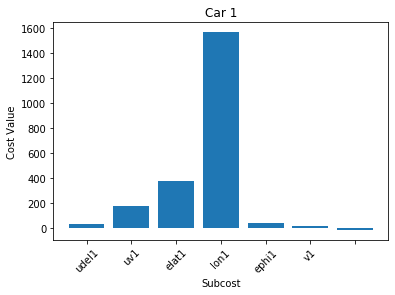

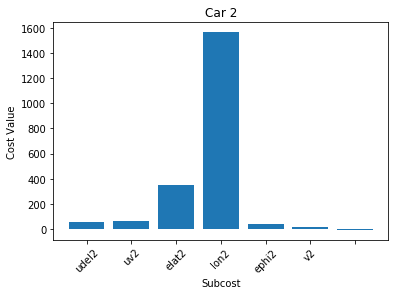

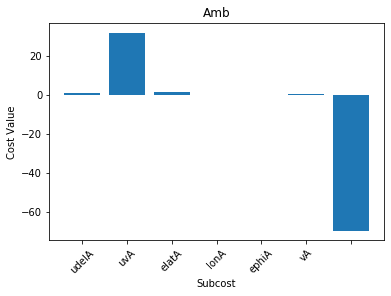

Text(0, 0.5, 'Cost Value')

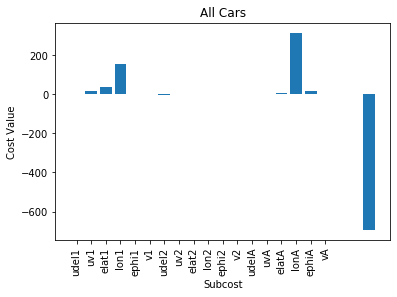

In [46]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [47]:
sol.value(x_opt)[3:5, 10:20]

array([[-0.38720141, -0.43956128, -0.49192116, -0.50674992, -0.48755244,
        -0.44804482, -0.40073318, -0.35407382, -0.31290433, -0.27939086],
       [ 3.51285435,  3.38099962,  3.17137338,  2.88666025,  2.56220294,
         2.23653045,  1.91940247,  1.61862896,  1.33948035,  1.08496037]])

In [48]:
dt

0.1

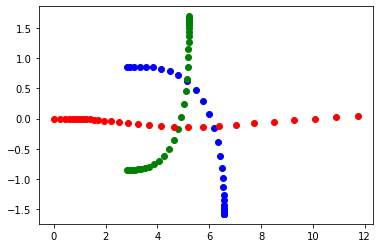

In [49]:
plt.plot(opti.debug.value(x_opt)[0,:],opti.debug.value(x_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[0,:],opti.debug.value(x2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[0,:],opti.debug.value(xamb_opt)[1,:],'o',c='r')
plt.show()

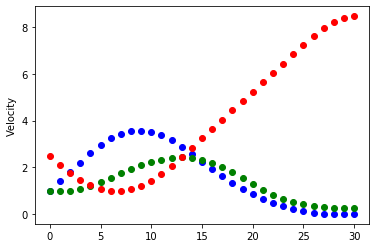

In [50]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

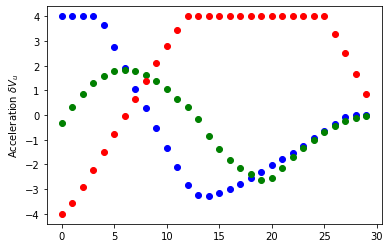

In [51]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

(-0.1, 2.8284271247461903)

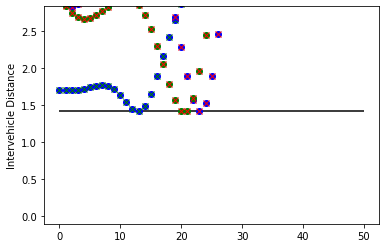

In [52]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [54]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [55]:
vid_fname = folder + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200206-154834/car.mp4


In [56]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [53]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

RuntimeError: Error in Opti::value [OptiNode] at .../casadi/core/optistack.cpp:175:
.../casadi/core/optistack_internal.cpp:502: Unknown: Opti decision variable 'opti3_x_10' of shape 1x31, belonging to a different instance of Opti.